In [148]:

import pandas as pd
import numpy as np
import requests
import io
import time
import os 
import sys
import networkx
import networkx as  nx
import random
current = os.getcwd()
parent = os.path.dirname(current)
sys.path.append(parent)
from  Datasets.get_pubchem_assay import load_csv_data_from_a_PubChem_assay, drop_sids_with_no_cids, download_smiles_given_cids_from_pubmed, load_smiles_and_activity_targets_from_a_PubChem_assay
from Datasets.get_pubchem_assay import draw_one_mol, draw_graphs
from Pipelines.SmilestoMaccs import SmitoMACCS
from Pipelines.SmilestoNxgraphs import SmitoNxGraphs
from Pipelines.NxGraphstoGraph2Vect import  NxGraphstoGraph2Vec
from Pipelines.NxtoPyggraphs import  NxGraphstoPyggraphs
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from General.downsample_data import downsample_binary_data
from Arhitectures.utils import get_report
import warnings
from torch_geometric.utils.convert import from_networkx
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer,LabelBinarizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from pylab import rcParams
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric import nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset, download_url
from networkx.drawing.nx_agraph import graphviz_layout,pygraphviz_layout
#warnings.filterwarnings("ignore")

# Load Pubchem Smiles

In [2]:

#Cytochrome panel assay with activity outcomes
smiles,y=load_smiles_and_activity_targets_from_a_PubChem_assay(1851)
smiles,y=np.array(smiles),np.array(y)
np.unique(y,return_counts=True)

190790


(array([0, 1]), array([5712, 1979], dtype=int64))

In [3]:
# Indicies of each class' observations
idx_inactives = np.where( y == 0 )[0]
idx_actives   = np.where( y == 1 )[0]

# Number of observations in each class
num_inactives = len(idx_inactives)
num_actives   = len(idx_actives)

# Randomly sample from inactives without replacement
np.random.seed(0)
idx_inactives_downsampled = np.random.choice(idx_inactives, size=num_actives, replace=False)
# Join together downsampled inactives with actives
smiles = np.vstack((smiles[idx_inactives_downsampled], smiles[idx_actives])).flatten()
y = np.hstack((y[idx_inactives_downsampled], y[idx_actives]))

In [4]:

print("# inactives : ", len(y) - y.sum())
print("# actives   : ", y.sum())

# inactives :  1979
# actives   :  1979


# Transform Smiles to NX graphs and then to PygGraphs

In [143]:
graphs=SmitoNxGraphs().transform(smiles[:150])
#embeddings=NxGraphstoGraph2Vec().transform(graphs)


c:\Users\cs843\Documents\PhD\December\App\Pipelines\SmilestoNxgraphs.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  else: return np.array(X)


In [9]:
graphs[0].edges(data=True)
smiles[0]

'NO'

## Show some graphs


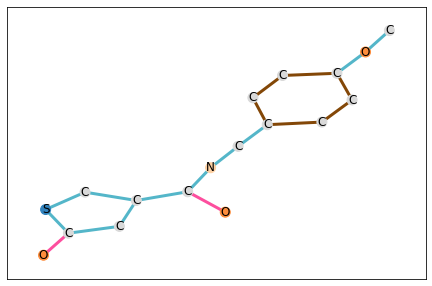

In [145]:
G=graphs[1]
draw_one_mol(G)
pos=nx.spring_layout(G)



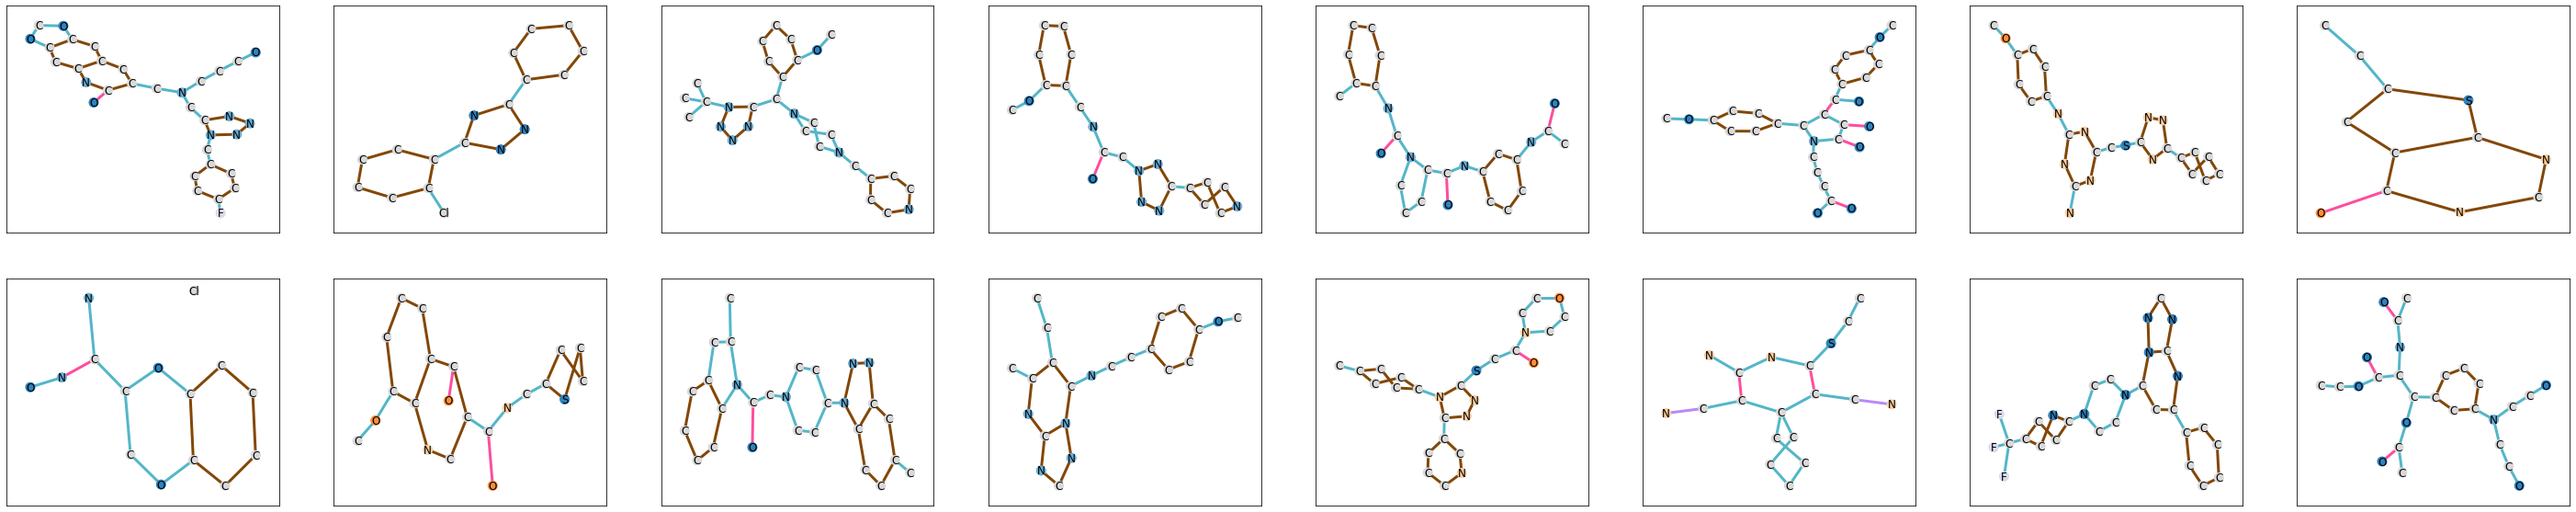

In [7]:


draw_graphs(graphs[1:17], num_per_line=8)
     

In [334]:
print(graphs[0].nodes(data=True))
print(graphs[0].edges(data=True))


[(0, {'atomic_num': 6, 'is_aromatic': False, 'atom_symbol': 'C'}), (1, {'atomic_num': 6, 'is_aromatic': False, 'atom_symbol': 'C'}), (2, {'atomic_num': 8, 'is_aromatic': False, 'atom_symbol': 'O'}), (3, {'atomic_num': 6, 'is_aromatic': False, 'atom_symbol': 'C'}), (4, {'atomic_num': 6, 'is_aromatic': False, 'atom_symbol': 'C'}), (5, {'atomic_num': 7, 'is_aromatic': False, 'atom_symbol': 'N'}), (6, {'atomic_num': 6, 'is_aromatic': False, 'atom_symbol': 'C'}), (7, {'atomic_num': 6, 'is_aromatic': False, 'atom_symbol': 'C'}), (8, {'atomic_num': 6, 'is_aromatic': False, 'atom_symbol': 'C'}), (9, {'atomic_num': 8, 'is_aromatic': False, 'atom_symbol': 'O'}), (10, {'atomic_num': 6, 'is_aromatic': True, 'atom_symbol': 'C'}), (11, {'atomic_num': 6, 'is_aromatic': True, 'atom_symbol': 'C'}), (12, {'atomic_num': 6, 'is_aromatic': True, 'atom_symbol': 'C'}), (13, {'atomic_num': 6, 'is_aromatic': True, 'atom_symbol': 'C'}), (14, {'atomic_num': 6, 'is_aromatic': True, 'atom_symbol': 'C'}), (15, {'at

In [ ]:
from copy import deepcopy
sub=deepcopy(graphs[0:20])

NxGraphs  label encoder and converter to pyg list of graphs

In [13]:

def get_unique_edge_labels(graph_list,label='bond_type'):
    """Pass in a list of a graphs and the name  of edge labels
    and  get a list of unique labels"""
    unique_labels={}
    for i,g in enumerate(graph_list):
        for j,edge in enumerate(g.edges(data=True)):
            try:
                unique_labels[edge[2][label]]=i
            except:continue
    return sorted(unique_labels.keys())


In [14]:
get_unique_edge_labels(graphs)

['AROMATIC', 'DOUBLE', 'SINGLE', 'TRIPLE']

In [12]:
def one_hot_encode_edge_labels(graph_list,label='bond_type', label_new='edge_attr', drop_label=False):
    "gets an edge attribute, encodes and creates a  new edge attribute called edge_attr"
    list_of_unique_labels=get_unique_edge_labels(graph_list,label)
    list_of_unique_labels=[str(x).lower().strip() for x in list_of_unique_labels]
    enc_edges  = preprocessing.LabelBinarizer()
    enc_edges.fit_transform(list_of_unique_labels)
    graph_list=deepcopy(graph_list)
    for i,G in enumerate(graph_list):
     #create a new attribute called edge_attr set to None
     nx.set_edge_attributes(G, 'None', label_new)
     for edge in G.edges(data=True):
        try:
            edge[2][label_new]= enc_edges.transform([edge[2][label].lower().strip()])[0].astype(float)
            if drop_label:
             del edge[2][label]
        except: 
           edge[2][label_new]=enc_edges.transform('None')
          
    return graph_list

In [15]:

def get_unique_node_labels(graph_list,label='atomic_num'):
    """Pass in a list of a graphs and the name  of edge labels
    and  get a list of unique labels"""
    unique_labels={}
    graph_list=deepcopy(graph_list)
    for i,g in enumerate(graph_list):
        for j,node in enumerate(g.nodes(data=True)):
            try:
                unique_labels[node[1][label]]=i
            except:continue
    return sorted(unique_labels.keys())

def one_hot_encode_node_labels(graph_list,labels, label_new='x', drop_label=False):
    "If  a list is given the labels will be one hot encoded and hstack by default"
    graph_list= deepcopy(graph_list)
    encoders=[  preprocessing.LabelBinarizer()  for i in range(len(labels))]
    for i, label in enumerate(list(labels)):
        list_of_unique_labels=get_unique_node_labels(graph_list,label)
        list_of_unique_labels=[x for x in list_of_unique_labels]
        encoders[i].fit_transform(list_of_unique_labels)
        
    for i,G in enumerate(graph_list):
        for node in G.nodes(data=True):
            z=[]
            for i,label in enumerate(labels):
                a=encoders[i].transform([node[1][label]])
                z=np.hstack((z,a[0]))
                if drop_label:
                   del node[1][label]
            node[1][label_new]=z.astype(float)
    return graph_list


        
  
    

In [16]:
from copy import deepcopy
get_unique_node_labels(graphs, 'atom_symbol')

['As', 'Br', 'C', 'Cl', 'F', 'N', 'Na', 'O', 'P', 'S']

In [17]:
graphs=one_hot_encode_edge_labels(graphs, drop_label=True)
graphs=one_hot_encode_node_labels(graphs, labels=['atomic_num', 'is_aromatic','atom_symbol'], drop_label=True)


## List of pygs graphs


In [18]:
list_of_pyg=NxGraphstoPyggraphs.transform(graphs,y)
list_of_pyg[0] 
#list_of_pyg

c:\Users\cs843\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\utils\convert.py:250: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  data[key] = torch.tensor(value)


Data(x=[2, 21], edge_index=[2, 2], edge_attr=[2, 4], num_nodes=2, num_edges=[2], y=0)

# Create an InMemoryDataset with the new graphs

In [168]:
class MyDataset(InMemoryDataset):
    def __init__(self, root, data_list, transform=None):
        self.data_list = data_list
        super().__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return 'data.pt'

    def process(self):
        torch.save(self.collate(self.data_list), self.processed_paths[0])

In [169]:
transform = T.Compose([
    T.RandomLinkSplit(num_val=0.05, num_test=0.2, is_undirected=True,
                      split_labels=True, add_negative_train_samples=True)
])
dataset=MyDataset(root='../Datasets/Pubchem/1851',data_list=list_of_pyg,transform=transform)

In [170]:

print()
print(f'Dataset: {dataset2}:')
print('====================')
print(f'Number of graphs: {len(dataset2)}')
print(f'Number of features: {dataset2.num_features}')
#print(f'Number of classes: {dataset.num_classes}')

data = dataset2[3][0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges/2}')
print(f'Average node degree: {data.num_edges/2 / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MyDataset(150):
Number of graphs: 150
Number of features: 21

Data(x=[25, 21], edge_index=[2, 40], edge_attr=[40, 4], num_edges=[40], y=[1], num_nodes=25, pos_edge_label=[20], pos_edge_label_index=[2, 20], neg_edge_label=[20], neg_edge_label_index=[2, 20])
Number of nodes: 25
Number of edges: 20.0
Average node degree: 0.80
Has isolated nodes: True
Has self-loops: False
Is undirected: True


c:\Users\cs843\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\transforms\random_link_split.py:220: UserWarning: There are not enough negative edges to satisfy the provided sampling ratio. The ratio will be adjusted to 0.00.
  warnings.warn(


In [161]:
train_data_list, val_data_list, test_data_list = [], [], []
for train_data, val_data, test_data in dataset2:
    try:
        if val_data.neg_edge_label is not None:
            train_data.x = F.normalize(train_data.x.float())
            val_data.x = F.normalize(val_data.x.float())
            test_data.x = F.normalize(test_data.x.float())
            train_data_list.append(train_data)
            val_data_list.append(val_data)
            test_data_list.append(test_data)
            
            
    except:
    
        continue

In [159]:
from torch_geometric.nn import VGAE, GCNConv
from matplotlib import pyplot as plt

class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [266]:
in_channels, out_channels, lr, n_epochs = dataset.num_features, 100, 1e-2, 100
gen_graphs, threshold, batch_size, add_self_loops = 100, 0.75, 10, False
model = VGAE(VariationalGCNEncoder(in_channels, out_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loader = DataLoader(train_data_list, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data_list, batch_size=batch_size)


c:\Users\cs843\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\transforms\random_link_split.py:220: UserWarning: There are not enough negative edges to satisfy the provided sampling ratio. The ratio will be adjusted to 0.00.
  warnings.warn(


In [267]:
def train():
    model.train()
    loss_all = 0
    for data in train_loader:
        optimizer.zero_grad()
        z = model.encode(data.x, data.edge_index)
        loss = model.recon_loss(z, data.pos_edge_label_index, data.neg_edge_label_index)
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
        loss.backward()
        loss_all += data.y.size(0) * float(loss)
        optimizer.step()
    return loss_all / len(train_loader.dataset)

In [268]:
@torch.no_grad()
def val(loader):
    model.eval()
    auc_all, ap_all = 0, 0
    for data in loader:
        z = model.encode(data.x, data.edge_index)
        auc, ap = model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)
        auc_all += data.y.size(0) * float(auc)
        ap_all += data.y.size(0) * float(ap)
    return auc_all / len(val_loader.dataset), ap_all / len(val_loader.dataset)

In [269]:
@torch.no_grad()
def test(loader):
    model.eval()
    graph_adj = []
    for graph, data in enumerate(loader):
        z = model.encode(data.x, data.edge_index)
        graph_adj.append(model.decoder.forward_all(z))
        if graph == gen_graphs - 1:
            break
    return graph_adj


In [270]:
for epoch in range(1, n_epochs + 1):
    loss = train()
    auc, ap = val(val_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, AUC: {auc:.4f}, AP: {ap:.4f}')


Epoch: 001, Loss: 5.2201, AUC: 0.5235, AP: 0.5792
Epoch: 002, Loss: 1.9693, AUC: 0.5928, AP: 0.6141
Epoch: 003, Loss: 1.7784, AUC: 0.6231, AP: 0.6420
Epoch: 004, Loss: 1.7236, AUC: 0.6463, AP: 0.6497
Epoch: 005, Loss: 1.6836, AUC: 0.6302, AP: 0.6482
Epoch: 006, Loss: 1.6841, AUC: 0.6427, AP: 0.6708
Epoch: 007, Loss: 1.7047, AUC: 0.6566, AP: 0.6963
Epoch: 008, Loss: 1.7028, AUC: 0.6565, AP: 0.7025
Epoch: 009, Loss: 1.7131, AUC: 0.6609, AP: 0.7013
Epoch: 010, Loss: 1.6282, AUC: 0.6392, AP: 0.6492
Epoch: 011, Loss: 1.6673, AUC: 0.6644, AP: 0.6989
Epoch: 012, Loss: 1.6523, AUC: 0.6630, AP: 0.6870
Epoch: 013, Loss: 1.6282, AUC: 0.6466, AP: 0.6675
Epoch: 014, Loss: 1.6395, AUC: 0.6625, AP: 0.6713
Epoch: 015, Loss: 1.6261, AUC: 0.6520, AP: 0.6649
Epoch: 016, Loss: 1.6085, AUC: 0.6511, AP: 0.6650
Epoch: 017, Loss: 1.6471, AUC: 0.6532, AP: 0.6664
Epoch: 018, Loss: 1.6455, AUC: 0.6526, AP: 0.6636
Epoch: 019, Loss: 1.6254, AUC: 0.6247, AP: 0.6418
Epoch: 020, Loss: 1.6220, AUC: 0.6637, AP: 0.6728


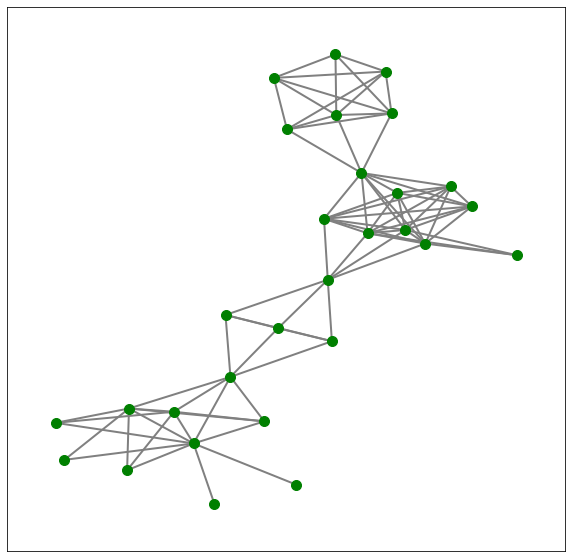

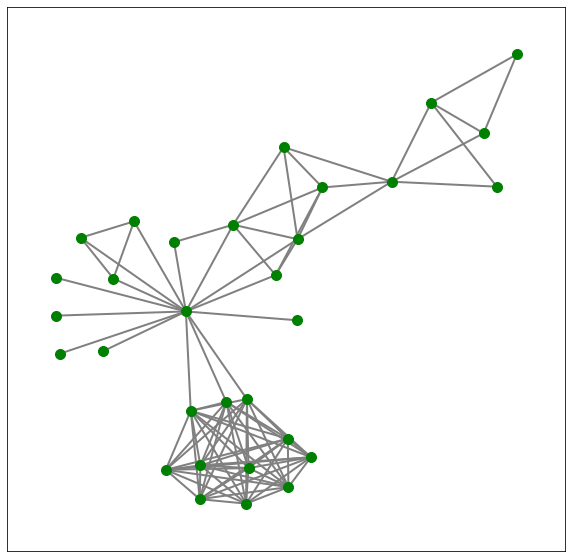

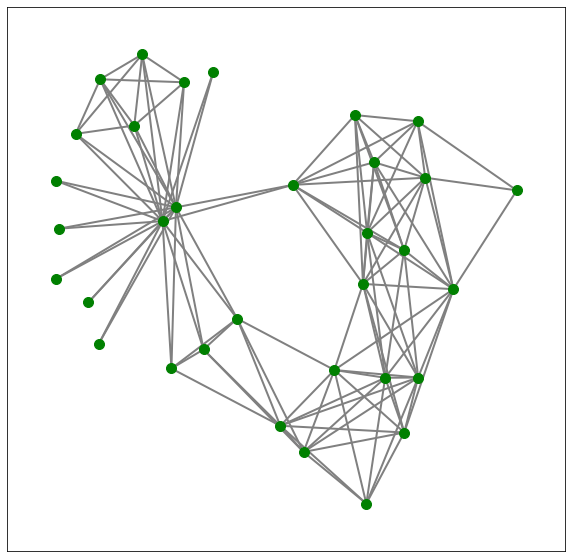

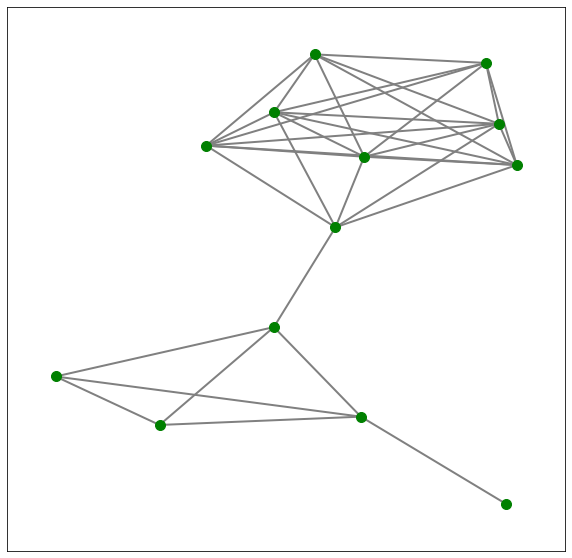

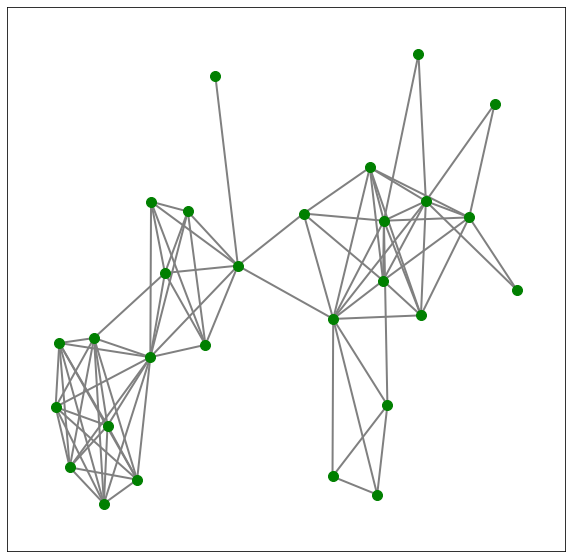

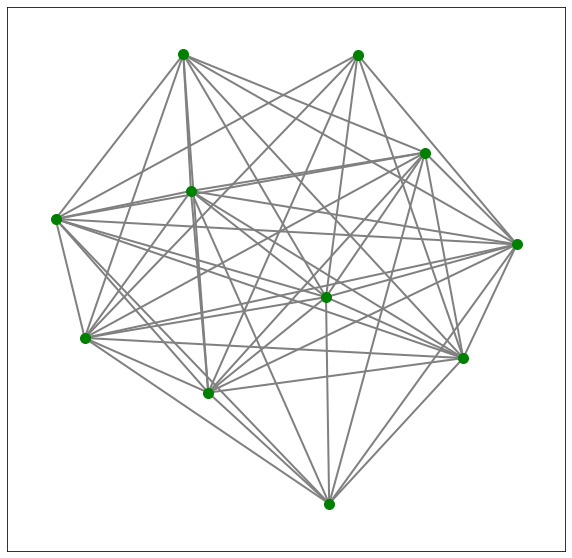

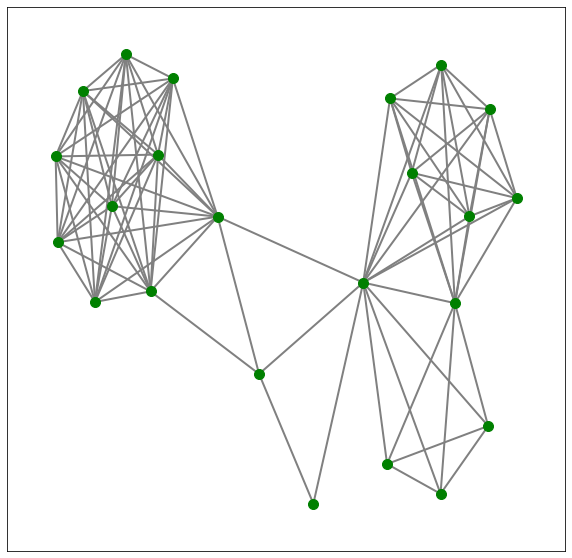

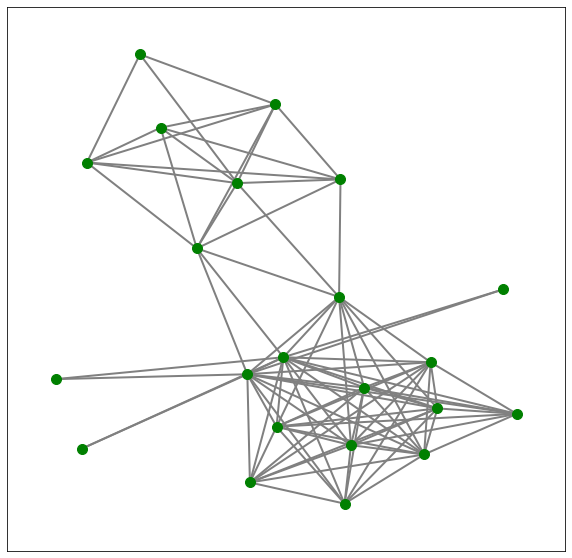

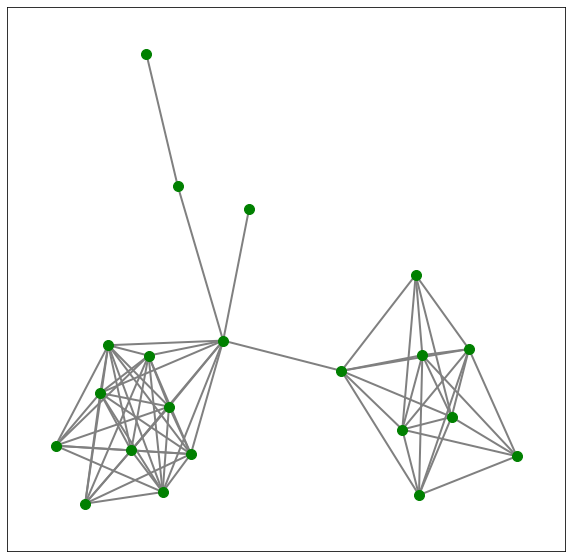

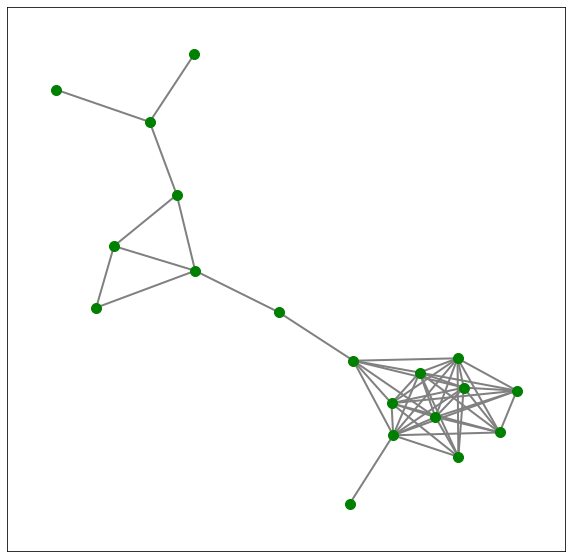

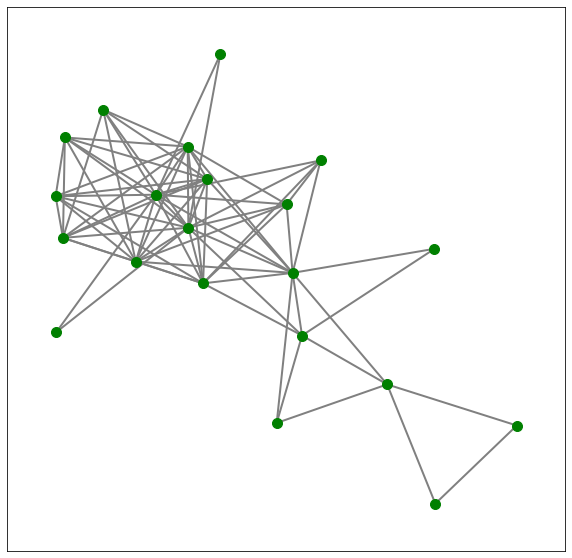

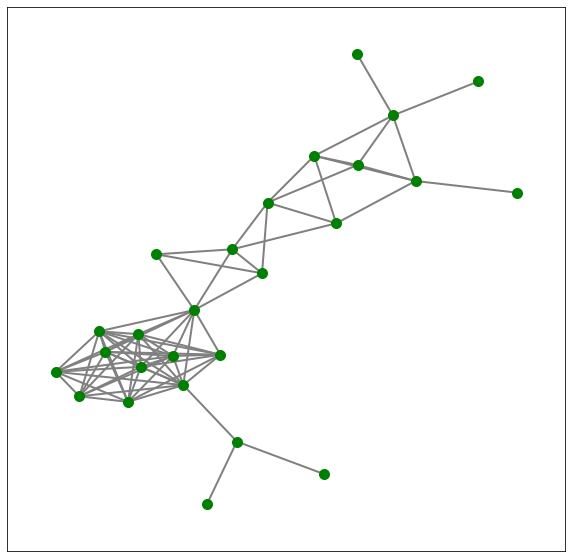

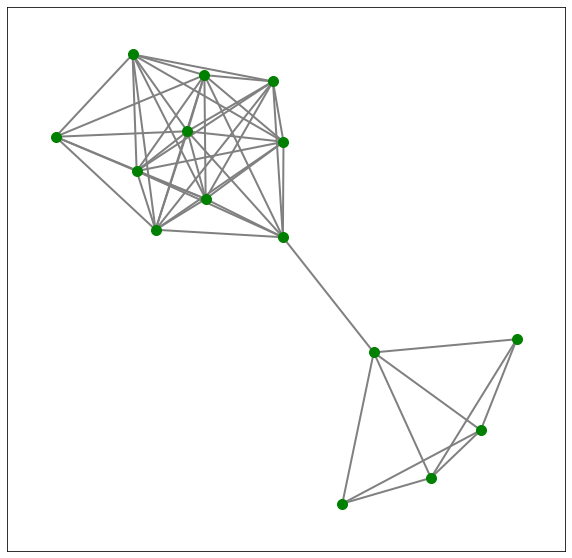

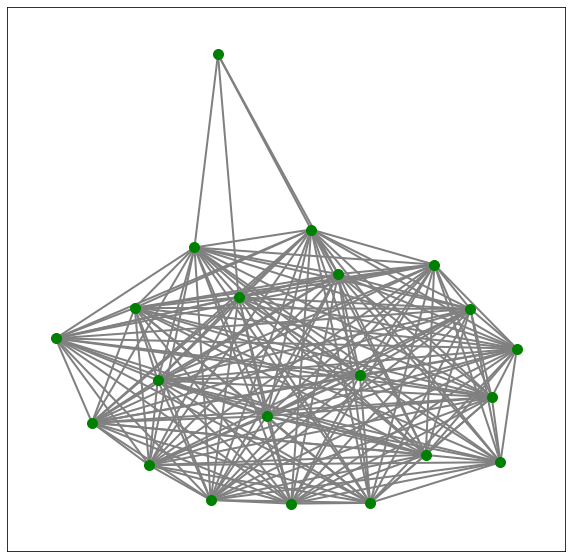

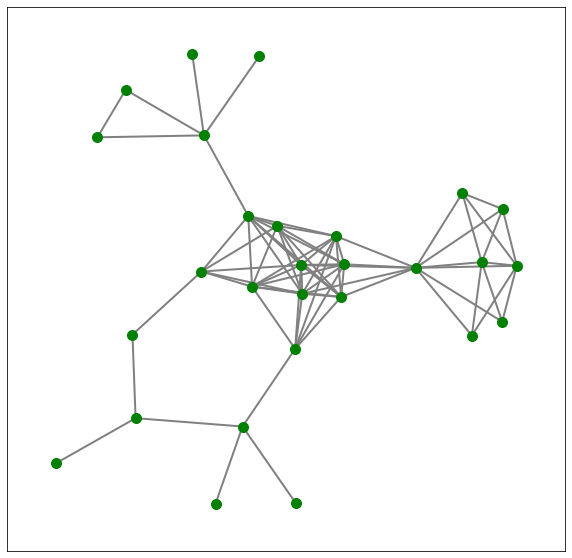

In [271]:
graphs = np.random.choice(len(test_data_list), gen_graphs, False)

test_graph_list = []
for g_id in graphs:
    test_graph_list.append(test_data_list[g_id])
test_loader = DataLoader(test_graph_list)
recon_adj = test(test_loader)
num_graphs=0
for i in range(gen_graphs):
    adj_binary = recon_adj[i] > threshold
    indices = torch.where(adj_binary)
    G = nx.Graph()
    if not add_self_loops:
        edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
        G.add_edges_from(edges)
    else:
        G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
    if not (nx.is_connected(G)):
        num_graphs-=1
        continue
    num_graphs+=1
    if num_graphs==gen_graphs:
        break
    pos=pygraphviz_layout(G)
    rcParams['figure.figsize'] = 10,10
    nx.draw_networkx_nodes(G,pos,
        #labels= get_labels(G),
        node_size=100,
        node_color='green',
        #edgecolors='black',
        
        )
    nx.draw_networkx_edges(G, pos,
        width=2,
        edge_color="gray",
       )
    plt.show()


In [265]:
recon_adj


[tensor([[0.7724, 0.7360, 0.6911, 0.7360, 0.7724, 0.7489, 0.6043, 0.3836, 0.3805,
          0.4142, 0.3482, 0.2916, 0.2792, 0.3013, 0.4439, 0.2792, 0.3826, 0.5407,
          0.6210, 0.3822, 0.3822, 0.6492, 0.6612],
         [0.7360, 0.8427, 0.8239, 0.8427, 0.7360, 0.6539, 0.4095, 0.2783, 0.3385,
          0.3194, 0.3339, 0.3206, 0.3997, 0.3583, 0.8537, 0.3997, 0.6252, 0.8536,
          0.9389, 0.3204, 0.3204, 0.9570, 0.9652],
         [0.6911, 0.8239, 0.8239, 0.8239, 0.6911, 0.6239, 0.4527, 0.3300, 0.4071,
          0.3323, 0.3315, 0.3504, 0.3889, 0.4058, 0.9015, 0.3889, 0.7037, 0.8970,
          0.9558, 0.3213, 0.3213, 0.9662, 0.9746],
         [0.7360, 0.8427, 0.8239, 0.8427, 0.7360, 0.6539, 0.4095, 0.2783, 0.3385,
          0.3194, 0.3339, 0.3206, 0.3997, 0.3583, 0.8537, 0.3997, 0.6252, 0.8536,
          0.9389, 0.3204, 0.3204, 0.9570, 0.9652],
         [0.7724, 0.7360, 0.6911, 0.7360, 0.7724, 0.7489, 0.6043, 0.3836, 0.3805,
          0.4142, 0.3482, 0.2916, 0.2792, 0.3013, 0.4439, 